## Maximum likelihood model fitting

In [10]:
# numpy is a standard numeric library... onyl time you dn't need this package is if you are manipulating strings (for eg doing file tidy up or something)
import numpy as np
# scipy has standard scientific libraries... note that scipy is MASSIVE, so sometimes there are some weird things that go on in importing
# best practice is to separately import important parts of scipy that you need, e.g. random or stats
import scipy as sp
import scipy.io as sio
import scipy.stats as stats

from scipy.optimize import minimize

# matplotlib is a set of plotting routines, based on the logic of matlab's plotting functionality 
import matplotlib.pyplot as plt
# seaborn is super useful for data visualization when using dataframes. It has the same logic and reproduces much
# of the functionality of ggplot in R 
import seaborn as sns
# pandas is a powerful library of data manipulation functions built around Series and DataFrames objects
import pandas as pd

# pickle is useful for saving compressed sets of files. Kind of like saving a whole workspace or something in matlab
import pickle
# importlib is another useful package that allows you to reload packages (as simply importing a package that has
# already been imported will not update it)
import importlib

In [11]:
ntr = 200 # num trials

# Basic Model

def mysimulation_basic(params,ntr):
    
    # params is a 5 vector of beta, etaP, etaN, decay, m
    
    V = np.zeros(4) # each option has a value
    beta = params[0]
    etaP = params[1]
    etaN = params[2]
    decay = params[3] # decay between zero and 1
    m = params[4] #scaling parameter
    
#     V[3] = 4
    
    p_win = [0.9,0.8,0.5,0.4]
    win_amount = [1,2,3,4]
    pun_dur = [5,10,30,40]
    
    Q = np.zeros([4,ntr])
    choice = []
    win = []
    probs = []
    
    
    for t in range(ntr):
        # print(t)

        Q[:,t] = V 
        
        # now we want to calculate the log likelihood of the choice on the current trial
        # we assume the prob of each choice follows a softmax rule
        # in log this looks like this
        
        p_action = np.exp(beta*V)/np.sum(np.exp(beta*V))
        
        # pick an action according to these probabilities
        chosen = np.random.choice([0,1,2,3], size=None, replace=True, p=p_action)
    
        # now we want to learn from feedback on this trial
        # win or lose?
        outcome = np.random.choice([1,0], size=None, replace=True, p=[p_win[chosen], 1-p_win[chosen]])
        
        if outcome:
            V[chosen] += etaP*(win_amount[chosen] - V[chosen])
            # this is the same as writing
            # V[chosen option] = V[chosen option] + eta*(reward - V[chosen option])
        else:
            # basic punishment model
            V[chosen] += etaN*(m*(-pun_dur[chosen]) - V[chosen])
             
        # values decay with time if unchosen
        ind = np.setdiff1d([0,1,2,3],chosen)
        V[ind] = decay*V[ind]
        
        choice.append(chosen)
        win.append(outcome)
        probs.append(p_action)
        
    return Q,choice,win,probs

In [12]:
ntr = 200 # num trials

# Independent Model

def mysimulation_ind(params,ntr):
    
    # params is a 8 vector of beta, etaP, etaN, decay, w1, w2, w3, w4
    
    V = np.zeros(4) # each option has a value
    beta = params[0]
    etaP = params[1]
    etaN = params[2]
    decay = params[3] # decay between zero and 1
    w1 = params[4]
    w2 = params[5]
    w3 = params[6]
    w4 = params[7]
    
#     V[3] = 4
    
    p_win = [0.9,0.8,0.5,0.4]
    win_amount = [1,2,3,4]
    pun_dur = [5,10,30,40]
    
    w = [w1,w2,w3,w4]
    
    
    Q = np.zeros([4,ntr])
    choice = []
    win = []
    probs = []
    
    
    for t in range(ntr):
        # print(t)

        Q[:,t] = V 
        
        # now we want to calculate the log likelihood of the choice on the current trial
        # we assume the prob of each choice follows a softmax rule
        # in log this looks like this
        
        p_action = np.exp(beta*V)/np.sum(np.exp(beta*V))
        
        # pick an action according to these probabilities
        chosen = np.random.choice([0,1,2,3], size=None, replace=True, p=p_action)
    
        # now we want to learn from feedback on this trial
        # win or lose?
        outcome = np.random.choice([1,0], size=None, replace=True, p=[p_win[chosen], 1-p_win[chosen]])
        
        if outcome:
            V[chosen] += etaP*(win_amount[chosen] - V[chosen])
            # this is the same as writing
            # V[chosen option] = V[chosen option] + eta*(reward - V[chosen option])
        else:
            # independent punishment model
            V[chosen] += etaN*(w[chosen]*(-pun_dur[chosen]) - V[chosen])
        
            
        
        # values decay with time if unchosen
        ind = np.setdiff1d([0,1,2,3],chosen)
        V[ind] = decay*V[ind]
        
        choice.append(chosen)
        win.append(outcome)
        probs.append(p_action)
        
    return Q,choice,win,probs
    

In [13]:
ntr = 200 # num trials

# Scaled + offset punishment model

def mysimulation_offset(params,ntr):
    
    # params is a 6 vector of beta, etaP, etaN, decay, m, b
    
    V = np.zeros(4) # each option has a value
    beta = params[0]
    etaP = params[1]
    etaN = params[2]
    decay = params[3] # decay between zero and 1
    m = params[4] # scaling parameter
    b = params[5] # offset
    
#     V[3] = 4
    
    p_win = [0.9,0.8,0.5,0.4]
    win_amount = [1,2,3,4]
    pun_dur = [5,10,30,40]
    
    Q = np.zeros([4,ntr])
    choice = []
    win = []
    probs = []
    
    
    for t in range(ntr):
        # print(t)

        Q[:,t] = V 
        
        # now we want to calculate the log likelihood of the choice on the current trial
        # we assume the prob of each choice follows a softmax rule
        # in log this looks like this
        
        p_action = np.exp(beta*V)/np.sum(np.exp(beta*V))
        
        # pick an action according to these probabilities
        chosen = np.random.choice([0,1,2,3], size=None, replace=True, p=p_action)
    
        # now we want to learn from feedback on this trial
        # win or lose?
        outcome = np.random.choice([1,0], size=None, replace=True, p=[p_win[chosen], 1-p_win[chosen]])
        
        if outcome:
            V[chosen] += etaP*(win_amount[chosen] - V[chosen])
            # this is the same as writing
            # V[chosen option] = V[chosen option] + eta*(reward - V[chosen option])
        else:
            # basic punishment model
            V[chosen] += etaN*(b + m * (-pun_dur[chosen]) - V[chosen])
             
        # values decay with time if unchosen
        ind = np.setdiff1d([0,1,2,3],chosen)
        V[ind] = decay*V[ind]
        
        choice.append(chosen)
        win.append(outcome)
        probs.append(p_action)
        
    return Q,choice,win,probs

In [14]:
# probs should be real probabilities

# Basic Model
Q,choice,win,probs = mysimulation_basic([1, 0.01, 0.07, 0.9, 0.5],ntr)

In [22]:
# Independent Model
#Q,choice,win,probs = mysimulation_ind([1, 0.01, 0.07, 0.9, 0.68,  0.828727,  0.530818, 0.621645],ntr)
Q,choice,win,probs = mysimulation_ind([0.0527, 0.04058, 0.01851, 0.9, 0.68,  0.828727,  0.530818, 0.621645],ntr)

In [16]:
# Scaled + offset Model
Q,choice,win,probs = mysimulation_offset([1, 0.01, 0.07, 0.9, 0.5, 0.01],ntr)

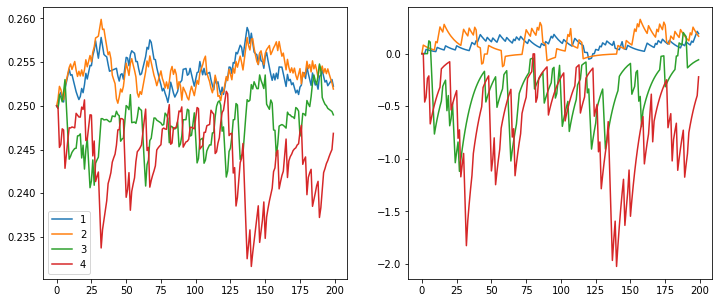

In [23]:
fig,ax = plt.subplots(1,2,figsize=[12,5])

ax[0].plot(np.array(probs))
ax[0].legend(['1','2','3','4'])

ax[1].plot(np.arange(ntr),Q.transpose())

(array([81.,  0.,  0., 59.,  0.,  0., 31.,  0.,  0., 29.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

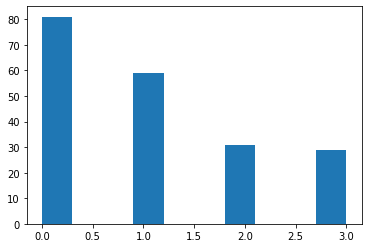

In [19]:
plt.hist(choice)

In [20]:
# let's check out what softmax does to choice probabilties for diff values

def softmax(x,beta):
    
    return np.exp(beta*x)/np.sum(np.exp(beta*x))

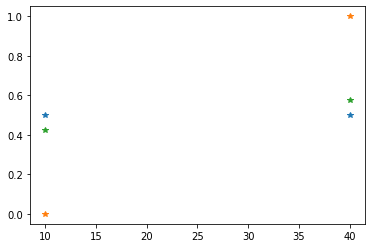

In [21]:
plt.plot([10,40],softmax(np.array([10,40]),0),'*')
plt.plot([10,40],softmax(np.array([10,40]),0.5),'*')
plt.plot([10,40],softmax(np.array([10,40]),0.01),'*')

